In [1]:
import os
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
os.chdir("/gdrive/My Drive/twitter_sentiment_analysis")

Based on https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis

In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, CuDNNLSTM
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [4]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.9

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 5
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

In [6]:
df = pd.read_csv("sentiment140.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}

def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 620 ms, sys: 1.21 ms, total: 622 ms
Wall time: 630 ms


## Preprocess Dataset

In [0]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    return " ".join(tokens)

In [11]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 13.8 s, sys: 121 ms, total: 13.9 s
Wall time: 14 s


In [12]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1440000
TEST size: 160000


## Word2Vec

In [0]:
documents = [_text.split() for _text in df_train.text] 

In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [0]:
w2v_model.build_vocab(documents)

In [16]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 32667


In [17]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(458303352, 607567168)

In [18]:
w2v_model.most_similar("business")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('biz', 0.6040492057800293),
 ('marketing', 0.4344160556793213),
 ('consulting', 0.4090287685394287),
 ('financial', 0.4076601564884186),
 ('education', 0.40316885709762573),
 ('strategic', 0.3976127505302429),
 ('strategies', 0.3964381515979767),
 ('management', 0.3790551424026489),
 ('consultant', 0.37636491656303406),
 ('community', 0.37610962986946106)]

## Preprocessing for training

Tokenize text, label encode targets

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 313441


In [0]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [0]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)

In [0]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

## Embedding Layer

In [23]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(313441, 300)


In [0]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

## Build model

In [25]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
#model.add(CuDNNLSTM(128))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          94032300  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 94,252,077
Trainable params: 219,777
Non-trainable params: 94,032,300
_________________________________________________________________


In [0]:
model.compile(loss="binary_crossentropy", optimizer=Adam(5e-4), metrics=["accuracy"])

In [0]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

## Train!

In [28]:
H = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=1, callbacks=callbacks)

Train on 1296000 samples, validate on 144000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1296000/1296000 [==============================] - 750s 579us/sample - loss: 0.5114 - acc: 0.7482 - val_loss: 0.4399 - val_acc: 0.7959
Epoch 2/5
1296000/1296000 [==============================] - 748s 578us/sample - loss: 0.4617 - acc: 0.7817 - val_loss: 0.4249 - val_acc: 0.8062
Epoch 3/5
1296000/1296000 [==============================] - 748s 577us/sample - loss: 0.4490 - acc: 0.7891 - val_loss: 0.4159 - val_acc: 0.8116
Epoch 4/5
1296000/1296000 [==============================] - 749s 578us/sample - loss: 0.4367 - acc: 0.7963 - val_loss: 0.4104 - val_acc: 0.8156
Epoch 5/5
1296000/1296000 [==============================] - 751s 579us/sample - loss: 0.4300 - acc: 0.8001 - val_loss: 0.4068 - val_acc: 0.8173


In [29]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

160000/160000 [==============================] - 37s 231us/sample - loss: 0.4043 - acc: 0.8167

ACCURACY: 0.81675
LOSS: 0.4042543496608734
CPU times: user 50.5 s, sys: 4.46 s, total: 54.9 s
Wall time: 37 s


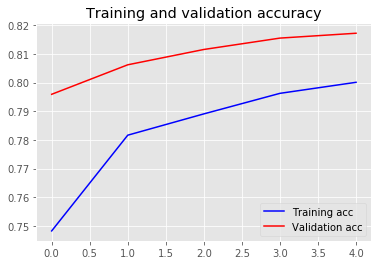

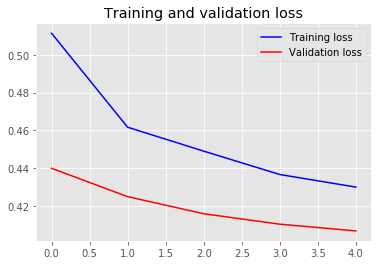

In [30]:
acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']
 
epochs = range(len(acc))

plt.style.use("ggplot")
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [0]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [0]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    text = preprocess(text)
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [42]:
predict("The house is on fire")

{'elapsed_time': 0.20146727561950684,
 'label': 'NEUTRAL',
 'score': 0.6397497057914734}

In [34]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

160000/160000 [==============================] - 22s 139us/sample
CPU times: user 9.52 s, sys: 1.82 s, total: 11.3 s
Wall time: 22.5 s


In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

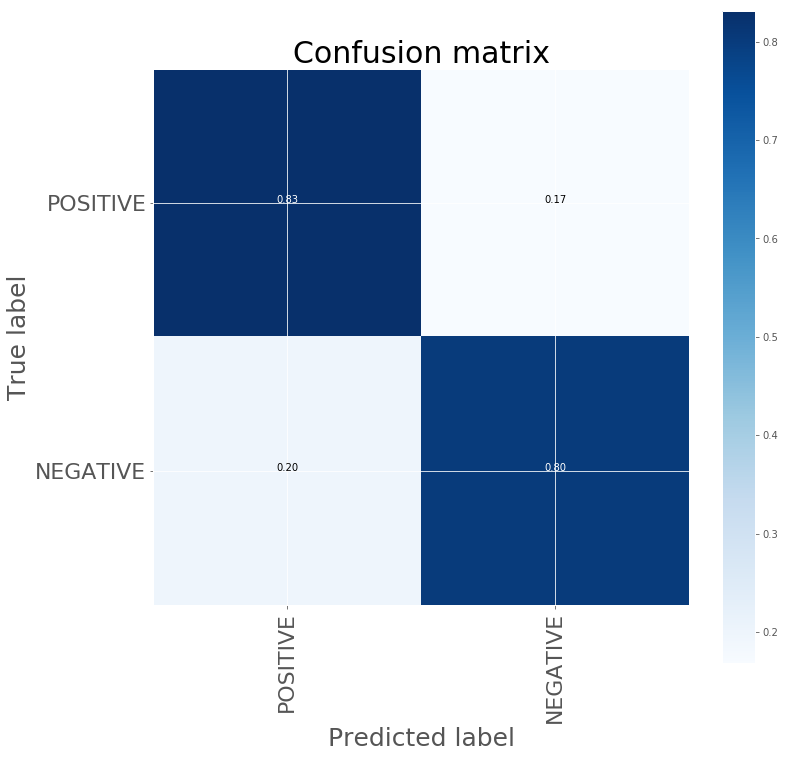

In [36]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [37]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.81      0.83      0.82     79812
    POSITIVE       0.83      0.80      0.81     80188

   micro avg       0.82      0.82      0.82    160000
   macro avg       0.82      0.82      0.82    160000
weighted avg       0.82      0.82      0.82    160000



In [0]:
import pickle

model.save("twitter.h5")
w2v_model.save("twitter.w2v")
pickle.dump(tokenizer, open("tokenizer.p", "wb"), protocol=0)
pickle.dump(encoder, open("encoder.p", "wb"), protocol=0)